In [93]:
import pandas as pd
from utils import *
import matplotlib.pyplot as plt
import warnings
import torch
from sklearn.preprocessing import MinMaxScaler
from vol_models import LSTMModel
from sklearn.metrics import mean_squared_error
from itertools import product
from tqdm import tqdm

warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Importing Libraries

In [94]:
import pandas as pd
from utils import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Read the data

In [95]:
data = pd.read_csv("Data/SPX/SPX_final_data.csv", index_col=0, parse_dates=True)
data = data.loc['2016':]
data.head()

,rv5,return
2016-01-04,0.018644,-0.015121
2016-01-05,0.007912,0.001960
2016-01-06,0.014094,-0.013133
2016-01-07,0.019777,-0.024133
2016-01-08,0.013277,-0.011079


In [96]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('Data/Indicators/ADS Index.csv', sep=';', index_col=0)

# Rename the column
df.columns = ['ADS']

# Convert the index to datetime
df.index = pd.to_datetime(df.index, format='%Y:%m:%d')

# Assuming 'data' is your other DataFrame and both 'data' and 'df' have a common column for merging
data = data.merge(df, left_index=True, right_index=True, how='inner')
# Print the DataFrame
data.head()

,rv5,return,ADS
2016-01-04,0.018644,-0.015121,-0.294595
2016-01-05,0.007912,0.001960,-0.279636
2016-01-06,0.014094,-0.013133,-0.265093
2016-01-07,0.019777,-0.024133,-0.250960
2016-01-08,0.013277,-0.011079,-0.237233


In [97]:
df = pd.read_csv('Data/Indicators/Economic Policy Index.csv', index_col=0)

df.index = pd.to_datetime(df.index)

data = data.merge(df, left_index=True, right_index=True, how='inner')

data.head()

,rv5,return,ADS,USEPUINDXD
2016-01-04,0.018644,-0.015121,-0.294595,106.94
2016-01-05,0.007912,0.001960,-0.279636,52.80
2016-01-06,0.014094,-0.013133,-0.265093,30.40
2016-01-07,0.019777,-0.024133,-0.250960,56.40
2016-01-08,0.013277,-0.011079,-0.237233,62.21


In [98]:
import yfinance as yf
import pandas as pd

ticker_names = ['^IRX', '^FVX', '^TYX', '^VIX', 'DX-Y.NYB']
symbol_names = ['13wb', '5yt', '30yt', 'VIX', 'Dollar_index']

for ticker, symbol in zip(ticker_names, symbol_names):
    # Download the data
    data_yahoo = yf.download(ticker, start='2000-01-01', end='2024-12-31')

    # Convert the index to datetime
    data_yahoo.index = pd.to_datetime(data_yahoo.index)
    
    data_yahoo = data_yahoo[['Close']]

    # Rename the column
    data_yahoo.columns = [symbol]

    # Merge the data with your existing dataframe
    data = data.merge(data_yahoo, left_index=True, right_index=True, how='inner')

data.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,rv5,return,ADS,USEPUINDXD,13wb,5yt,30yt,VIX,Dollar_index
2016-01-04,0.018644,-0.015121,-0.294595,106.94,0.155,1.735,2.990,20.700001,98.870003
2016-01-05,0.007912,0.001960,-0.279636,52.80,0.205,1.724,3.011,19.340000,99.400002
2016-01-06,0.014094,-0.013133,-0.265093,30.40,0.205,1.650,2.940,20.590000,99.180000
2016-01-07,0.019777,-0.024133,-0.250960,56.40,0.190,1.612,2.926,24.990000,98.220001
2016-01-08,0.013277,-0.011079,-0.237233,62.21,0.190,1.578,2.920,27.010000,98.540001


In [99]:
data['13wb_return'] = np.log(data['13wb'] / data['13wb'].shift(1))
data.dropna(inplace=True)

In [100]:
data['credit_spread'] = data['30yt'] - data['13wb']

In [101]:
data.drop(['13wb', '5yt', '30yt'], axis = 1, inplace = True)

In [102]:
data['dollar_index_return'] = np.log(data['Dollar_index'] / data['Dollar_index'].shift(1))
data.drop(['Dollar_index'], axis=1, inplace=True)
data.dropna(inplace=True)

In [103]:
data_yahoo = yf.download('^SPX', start='2000-01-01', end='2024-12-31')

# Convert the index to datetime
data_yahoo.index = pd.to_datetime(data_yahoo.index)

data_yahoo = data_yahoo[['Volume']]


data = data.merge(data_yahoo, left_index=True, right_index=True, how='inner')

data.head()

[*********************100%%**********************]  1 of 1 completed


,rv5,return,ADS,USEPUINDXD,VIX,13wb_return,credit_spread,dollar_index_return,Volume
2016-01-06,0.014094,-0.013133,-0.265093,30.40,20.590000,0.000000,2.735,-0.002216,4336660000
2016-01-07,0.019777,-0.024133,-0.250960,56.40,24.990000,-0.075986,2.736,-0.009727,5076590000
2016-01-08,0.013277,-0.011079,-0.237233,62.21,27.010000,0.000000,2.730,0.003253,4664940000
2016-01-11,0.012732,0.000874,-0.198630,65.10,24.299999,-0.082238,2.781,0.001926,4607290000
2016-01-12,0.013360,0.007985,-0.186875,67.32,22.469999,0.182322,2.672,0.002428,4887260000


In [104]:
data.iloc[:,1:] = data.iloc[:,1:].shift(1)
data = data.iloc[1:]

In [105]:
test_data = data.iloc[-int(len(data) * 0.1):]
data = data.iloc[:-int(len(data) * 0.1)]

In [106]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from itertools import product
from vol_models import LSTMModel

def scale_data(data):
    # Create two separate scalers for input and output
    scaler = MinMaxScaler(feature_range=(-1, 1))

    data = scaler.fit_transform(data)

    return data, scaler

def get_train_and_validation_data(X, y, split = 8 / 9):
    
    # Convert to PyTorch tensors
    X_train = X[:int(X.shape[0] * split),:,:]
    y_train = y[:int(X.shape[0] * split),:]
    X_val = X[int(X.shape[0] * split):,:,:]
    y_val = y[int(X.shape[0] * split):,:]
    
    
    return X_train, y_train, X_val, y_val


In [107]:
def predict_val_LSTM(X_train, y_train, X_val, hidden_dim, layer_dim, lr):
    model = LSTMModel(X_train.shape[-1], hidden_dim, layer_dim, y_train.shape[-1])
    # Define a loss function and an optimizer
    criterion = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Train the model
    for epoch in tqdm(range(100)):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        predictions_val = model(X_val)
    return predictions_val , model
    

In [108]:
def LSTM_hyper_tuning(data, hidden_dim_values, layer_dim_values, lr_values):
    X = data.iloc[:, 1:].values
    y = data.iloc[:, 0].values
    
    
    X, scaler_X = scale_data(X)
    y, scaler_y = scale_data(y.reshape(-1, 1))

    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
    
    print(X.shape)
    print(y.shape)

    X_train, y_train, X_val, y_val = get_train_and_validation_data(X, y)
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    X_val = torch.from_numpy(X_val).float()
    y_val = torch.from_numpy(y_val).float()

    # Initialize variables to store the best model and the lowest MSE
    best_model = None
    best_lr = None
    best_predictions = None
    lowest_mse = float('inf')

    # Iterate over all combinations of hyperparameters
    for hidden_dim, layer_dim, lr in product(hidden_dim_values, layer_dim_values, lr_values):
        # Define the LSTM model
        predictions_val, model = predict_val_LSTM(X_train, y_train, X_val, hidden_dim, layer_dim, lr)
        # Invert the predictions back to the original scale
        # predictions_val = scaler_y.inverse_transform(predictions_val.detach().numpy().reshape(-1, 1))
        # real_val = scaler_y.inverse_transform(y_val.detach().numpy().reshape(-1, 1))
        # plt.plot(predictions_val, color='red')
        # plt.plot(y_val)

        # Calculate the MSE
        y_val_unscaled = scaler_y.inverse_transform(y_val.numpy())
        predictions_val = scaler_y.inverse_transform(predictions_val.numpy()) 
        rmse = mean_squared_error(predictions_val, y_val_unscaled) ** 0.5

        # Update the best model and the lowest MSE
        if rmse < lowest_mse:
            best_model = model
            best_lr = lr
            lowest_rmse = rmse
            best_predictions = predictions_val

        print(f"RMSE for LSTM model with hidden_dim={hidden_dim}, layer_dim={layer_dim}, lr={lr}: {rmse}")

    print(f"Lowest RMSE: {lowest_rmse}")
    best_model_params = {'hidden_dim': best_model.hidden_dim, 'layer_dim': best_model.layer_dim, 'lr': best_lr}
    return best_model_params , best_model, best_predictions , y_val_unscaled
    


In [109]:
data.head()

,rv5,return,ADS,USEPUINDXD,VIX,13wb_return,credit_spread,dollar_index_return,Volume
2016-01-07,0.019777,-0.013133,-0.265093,30.40,20.590000,0.000000,2.735,-0.002216,4.336660e+09
2016-01-08,0.013277,-0.024133,-0.250960,56.40,24.990000,-0.075986,2.736,-0.009727,5.076590e+09
2016-01-11,0.012732,-0.011079,-0.237233,62.21,27.010000,0.000000,2.730,0.003253,4.664940e+09
2016-01-12,0.013360,0.000874,-0.198630,65.10,24.299999,-0.082238,2.781,0.001926,4.607290e+09
2016-01-13,0.014332,0.007985,-0.186875,67.32,22.469999,0.182322,2.672,0.002428,4.887260e+09


In [116]:
data_copy = data.copy()

In [117]:
data['return'] = np.abs(data['return'])

In [118]:
hidden_dim_values = [30, 50, 70]
layer_dim_values = [1, 2, 3]
lr_values = [0.1, 0.01, 0.001]

best_model_params, best_model, best_prediction , real_value = LSTM_hyper_tuning(data, hidden_dim_values, layer_dim_values, lr_values)

(1689, 1, 8)
(1689, 1)


100%|██████████| 100/100 [00:00<00:00, 145.65it/s]


RMSE for LSTM model with hidden_dim=30, layer_dim=1, lr=0.1: 0.005144803974379675


100%|██████████| 100/100 [00:00<00:00, 158.86it/s]


RMSE for LSTM model with hidden_dim=30, layer_dim=1, lr=0.01: 0.00484524389253887


100%|██████████| 100/100 [00:00<00:00, 155.07it/s]


RMSE for LSTM model with hidden_dim=30, layer_dim=1, lr=0.001: 0.006011538381644565


100%|██████████| 100/100 [00:01<00:00, 93.80it/s]


RMSE for LSTM model with hidden_dim=30, layer_dim=2, lr=0.1: 0.006223581554744817


100%|██████████| 100/100 [00:01<00:00, 91.15it/s]


RMSE for LSTM model with hidden_dim=30, layer_dim=2, lr=0.01: 0.004885564155404414


100%|██████████| 100/100 [00:01<00:00, 92.40it/s]


RMSE for LSTM model with hidden_dim=30, layer_dim=2, lr=0.001: 0.00668545694092895


100%|██████████| 100/100 [00:01<00:00, 66.42it/s]


RMSE for LSTM model with hidden_dim=30, layer_dim=3, lr=0.1: 0.004831778853719572


100%|██████████| 100/100 [00:01<00:00, 66.16it/s]


RMSE for LSTM model with hidden_dim=30, layer_dim=3, lr=0.01: 0.004944371192785905


100%|██████████| 100/100 [00:01<00:00, 67.83it/s]


RMSE for LSTM model with hidden_dim=30, layer_dim=3, lr=0.001: 0.006196420327070777


100%|██████████| 100/100 [00:00<00:00, 126.14it/s]


RMSE for LSTM model with hidden_dim=50, layer_dim=1, lr=0.1: 0.00489230072265122


100%|██████████| 100/100 [00:00<00:00, 128.43it/s]


RMSE for LSTM model with hidden_dim=50, layer_dim=1, lr=0.01: 0.004857827502279001


100%|██████████| 100/100 [00:00<00:00, 120.97it/s]


RMSE for LSTM model with hidden_dim=50, layer_dim=1, lr=0.001: 0.008051729421264812


100%|██████████| 100/100 [00:01<00:00, 62.04it/s]


RMSE for LSTM model with hidden_dim=50, layer_dim=2, lr=0.1: 0.0049161553034695465


100%|██████████| 100/100 [00:01<00:00, 61.44it/s]


RMSE for LSTM model with hidden_dim=50, layer_dim=2, lr=0.01: 0.0048647720511416


100%|██████████| 100/100 [00:01<00:00, 62.29it/s]


RMSE for LSTM model with hidden_dim=50, layer_dim=2, lr=0.001: 0.005704730219078314


100%|██████████| 100/100 [00:02<00:00, 42.92it/s]


RMSE for LSTM model with hidden_dim=50, layer_dim=3, lr=0.1: 0.006239667970382618


100%|██████████| 100/100 [00:02<00:00, 42.19it/s]


RMSE for LSTM model with hidden_dim=50, layer_dim=3, lr=0.01: 0.00520253631066625


100%|██████████| 100/100 [00:02<00:00, 42.05it/s]


RMSE for LSTM model with hidden_dim=50, layer_dim=3, lr=0.001: 0.004925955963760983


100%|██████████| 100/100 [00:01<00:00, 88.81it/s]


RMSE for LSTM model with hidden_dim=70, layer_dim=1, lr=0.1: 0.004946455775294094


100%|██████████| 100/100 [00:01<00:00, 86.36it/s]


RMSE for LSTM model with hidden_dim=70, layer_dim=1, lr=0.01: 0.004750795970777241


100%|██████████| 100/100 [00:01<00:00, 87.59it/s]


RMSE for LSTM model with hidden_dim=70, layer_dim=1, lr=0.001: 0.007890729187198475


100%|██████████| 100/100 [00:02<00:00, 44.05it/s]


RMSE for LSTM model with hidden_dim=70, layer_dim=2, lr=0.1: 0.005420905275848211


100%|██████████| 100/100 [00:02<00:00, 44.21it/s]


RMSE for LSTM model with hidden_dim=70, layer_dim=2, lr=0.01: 0.004948692758597168


100%|██████████| 100/100 [00:02<00:00, 44.74it/s]


RMSE for LSTM model with hidden_dim=70, layer_dim=2, lr=0.001: 0.004744113060372821


100%|██████████| 100/100 [00:03<00:00, 29.76it/s]


RMSE for LSTM model with hidden_dim=70, layer_dim=3, lr=0.1: 0.004805144423895714


100%|██████████| 100/100 [00:03<00:00, 30.16it/s]


RMSE for LSTM model with hidden_dim=70, layer_dim=3, lr=0.01: 0.0049861984057335915


100%|██████████| 100/100 [00:03<00:00, 29.47it/s]

RMSE for LSTM model with hidden_dim=70, layer_dim=3, lr=0.001: 0.0048237037356639164
Lowest RMSE: 0.0048237037356639164


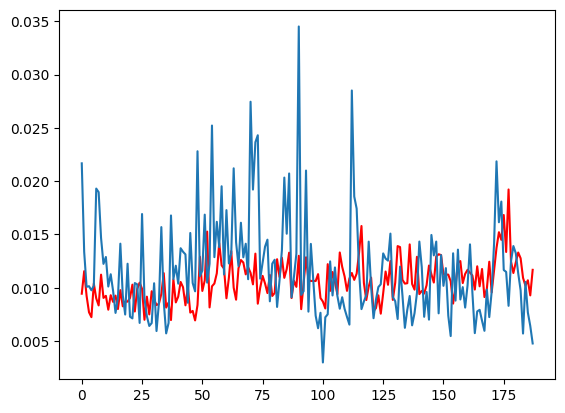

In [113]:
plt.plot(best_prediction, color='red')
plt.plot(real_value)

In [114]:
def permutation_feature_importance(model, X_val, y_val, criterion):
    # Calculate the validation loss with the original data
    model.eval()
    with torch.no_grad():
        outputs = model(X_val)
        loss = criterion(outputs, y_val)
    original_loss = loss.item()
    print(original_loss)

    # Initialize an array to hold the feature importances
    feature_importances = np.zeros(X_val.shape[2])

    # Permute each feature and calculate the validation loss
    for i in range(X_val.shape[2]):
        X_val_permuted = X_val.clone()
        column_to_permute = X_val_permuted[:, 0, i]
        # Shuffle the values of the selected column
        permuted_column = column_to_permute[torch.randperm(column_to_permute.size(0))]
        # Assign the shuffled values back to the original tensor
        X_val_permuted[:, 0, i] = permuted_column
        
        with torch.no_grad():
            outputs = model(X_val_permuted)
            loss = criterion(outputs, y_val)
        permuted_loss = loss.item()

        # The feature importance is the increase in the validation loss
        feature_importances[i] = permuted_loss - original_loss

    return feature_importances


In [189]:
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values


X, scaler_X = scale_data(X)
y, scaler_y = scale_data(y.reshape(-1, 1))

X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

print(X.shape)
print(y.shape)

X_train, y_train, X_val, y_val = get_train_and_validation_data(X, y)
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()

feature_importance = permutation_feature_importance(best_model, X_val, y_val, nn.MSELoss(reduction='mean'))
print(data.columns[1:], feature_importance)

(1689, 1, 8)
(1689, 1)
0.00869067758321762
Index(['return', 'ADS', 'USEPUINDXD', 'VIX', '13wb_return', 'credit_spread',
       'dollar_index_return', 'Volume'],
      dtype='object') [ 3.38085927e-04 -3.75863165e-05 -2.29272991e-05  6.88634813e-04
 -2.06269324e-05 -4.55575064e-05  4.87132929e-04 -1.40747987e-04]


In [190]:
import shap
# Initialize the explainer

explainer = shap.DeepExplainer(best_model, X_train)

# Calculate the SHAP values
shap_values = explainer.shap_values(X_val)

In [201]:
shap_values = shap_values.reshape(shap_values.shape[0], shap_values.shape[2])

X_val_ = X_val.reshape(X_val.shape[0], X_val.shape[2])
X_val_ = np.array(X_val_)

shap.summary_plot(shap_values, X_val_, feature_names=data.columns[1:])

(188, 8)

In [60]:
hidden_dim_values = [30, 50, 70]
layer_dim_values = [1, 2, 3]
lr_values = [0.1, 0.01, 0.001]

data_return = data[['rv5', 'return']]

best_model_params, best_model, best_prediction , real_value = LSTM_hyper_tuning(data_return, hidden_dim_values, layer_dim_values, lr_values)

(1689, 1, 1)
(1689, 1)


100%|██████████| 100/100 [00:00<00:00, 155.25it/s]


RMSE for LSTM model with hidden_dim=30, layer_dim=1, lr=0.1: 0.006103085264292291


100%|██████████| 100/100 [00:00<00:00, 153.50it/s]


RMSE for LSTM model with hidden_dim=30, layer_dim=1, lr=0.01: 0.00590089464659006


100%|██████████| 100/100 [00:00<00:00, 162.91it/s]


RMSE for LSTM model with hidden_dim=30, layer_dim=1, lr=0.001: 0.024074013754875424


100%|██████████| 100/100 [00:01<00:00, 99.04it/s]


RMSE for LSTM model with hidden_dim=30, layer_dim=2, lr=0.1: 0.005851950449137168


100%|██████████| 100/100 [00:01<00:00, 97.90it/s]


RMSE for LSTM model with hidden_dim=30, layer_dim=2, lr=0.01: 0.005848867088875141


100%|██████████| 100/100 [00:01<00:00, 96.94it/s]


RMSE for LSTM model with hidden_dim=30, layer_dim=2, lr=0.001: 0.007425335909274711


100%|██████████| 100/100 [00:01<00:00, 70.68it/s]


RMSE for LSTM model with hidden_dim=30, layer_dim=3, lr=0.1: 0.00592173759336342


100%|██████████| 100/100 [00:01<00:00, 70.16it/s]


RMSE for LSTM model with hidden_dim=30, layer_dim=3, lr=0.01: 0.006005440056223665


100%|██████████| 100/100 [00:01<00:00, 69.27it/s]


RMSE for LSTM model with hidden_dim=30, layer_dim=3, lr=0.001: 0.005417587004491212


100%|██████████| 100/100 [00:00<00:00, 139.08it/s]


RMSE for LSTM model with hidden_dim=50, layer_dim=1, lr=0.1: 0.006058422345580479


100%|██████████| 100/100 [00:00<00:00, 138.57it/s]


RMSE for LSTM model with hidden_dim=50, layer_dim=1, lr=0.01: 0.006173381287748617


100%|██████████| 100/100 [00:00<00:00, 140.87it/s]


RMSE for LSTM model with hidden_dim=50, layer_dim=1, lr=0.001: 0.009330633713260225


100%|██████████| 100/100 [00:01<00:00, 78.10it/s]


RMSE for LSTM model with hidden_dim=50, layer_dim=2, lr=0.1: 0.006052196943642094


100%|██████████| 100/100 [00:01<00:00, 78.43it/s]


RMSE for LSTM model with hidden_dim=50, layer_dim=2, lr=0.01: 0.006003576083077124


100%|██████████| 100/100 [00:01<00:00, 74.49it/s]


RMSE for LSTM model with hidden_dim=50, layer_dim=2, lr=0.001: 0.00551489861482228


100%|██████████| 100/100 [00:01<00:00, 51.60it/s]


RMSE for LSTM model with hidden_dim=50, layer_dim=3, lr=0.1: 0.005865486876395437


100%|██████████| 100/100 [00:02<00:00, 44.53it/s]


RMSE for LSTM model with hidden_dim=50, layer_dim=3, lr=0.01: 0.005861518822817648


100%|██████████| 100/100 [00:02<00:00, 41.73it/s]


RMSE for LSTM model with hidden_dim=50, layer_dim=3, lr=0.001: 0.006595929547968869


100%|██████████| 100/100 [00:01<00:00, 77.71it/s]


RMSE for LSTM model with hidden_dim=70, layer_dim=1, lr=0.1: 0.006088670618533041


100%|██████████| 100/100 [00:01<00:00, 84.19it/s]


RMSE for LSTM model with hidden_dim=70, layer_dim=1, lr=0.01: 0.0059629996439638615


100%|██████████| 100/100 [00:01<00:00, 89.85it/s]


RMSE for LSTM model with hidden_dim=70, layer_dim=1, lr=0.001: 0.005437259012984624


100%|██████████| 100/100 [00:02<00:00, 44.86it/s]


RMSE for LSTM model with hidden_dim=70, layer_dim=2, lr=0.1: 0.006067125797661014


100%|██████████| 100/100 [00:02<00:00, 39.62it/s]


RMSE for LSTM model with hidden_dim=70, layer_dim=2, lr=0.01: 0.0059901506830225045


100%|██████████| 100/100 [00:02<00:00, 45.21it/s]


RMSE for LSTM model with hidden_dim=70, layer_dim=2, lr=0.001: 0.005671093103236605


100%|██████████| 100/100 [00:03<00:00, 30.89it/s]


RMSE for LSTM model with hidden_dim=70, layer_dim=3, lr=0.1: 0.005925852262811538


100%|██████████| 100/100 [00:03<00:00, 30.85it/s]


RMSE for LSTM model with hidden_dim=70, layer_dim=3, lr=0.01: 0.005972390717372703


100%|██████████| 100/100 [00:03<00:00, 31.04it/s]

RMSE for LSTM model with hidden_dim=70, layer_dim=3, lr=0.001: 0.005853545746329613
Lowest RMSE: 0.005853545746329613
